In [1]:
%matplotlib ipympl

In [2]:
import cv2
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation as R
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import bpy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

In [3]:
import sys
import os

sys.path.append(
    os.path.join(
        os.path.dirname(os.path.abspath('__file__')),
        os.pardir,
        os.pardir,
        )
    )


In [4]:
from backend.core.modules.data_objects import CameraData, VideoData, HumanPose, Body, ContactPoints
from backend.core.modules.cam_utils import get_extrinsic_matrix
from backend.core.modules.video_utils import frame_to_timestamp
from backend.core.modules.maths_utils import compute_transformation_matrix, compute_translation, coords_transformation_3D, solvePnP, polar2cartesian_xz, cylindrical2cartesian, spline_smoothing
from backend.core.modules.rendering_utils import get_pair_2d_3d, place_camera_object, make_camera_data, render_model
from backend.core.modules.image_utils import gammaCorrection, invert
from backend.core.modules.body_keypoints import KEYPOINTS, get_kp_coords, get_kp_idx, get_plot_style

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 3D Model

Camera Matrix

In [5]:
database_path = os.path.join(
    os.path.dirname(os.path.abspath('__file__')),
    os.pardir,
    os.pardir,
    'database',
    )

video_path = os.path.join(database_path, '1StarChoss_trimmed.mp4')
# video_path = os.path.join(database_path, 'joe_sacrifices.mp4')
# video_path = os.path.join(database_path, '1StarChoss_trimmed_rotate.mp4')
blender_model_path = os.path.join(database_path, 'MB2024.blend')
yolomodel_path = 'models/best.pt'
featurematch_img_path = os.path.join(database_path, 'MB2024_matching.png')

In [6]:
cam_json = {
    "fx": 1353.6915950245486,
    "fy": 1357.5577115711324,
    "cx": 538.9620188123179,
    "cy": 961.5329984766928,
    "dist_coeffs": [
        0.045870044322073686,
        -0.39564683084494173,
        -0.0020515588805692024,
        0.0015103837799576112,
        1.0718061310340865
    ]
}

In [7]:
weight = 56

In [8]:
cameradata = CameraData(cam_json)

## Functions

Redndering Camera Orientation

In [9]:
def cam_position2rvec(theta):
    return np.array([
        [np.deg2rad(0)],
        [np.deg2rad(theta)], 
        [np.deg2rad(0)]
    ])

In [10]:
def add_camera_vec(cam_data, tvec: np.ndarray, rvec: np.ndarray, name: str):
    """
    cam_data: bpy.data.cameras
    tvec: translation vector
    rvec: rotation vector
    """
    cam_obj = bpy.data.objects.new(name, cam_data)
    cam_obj.location = (tvec[0][0], tvec[1][0], tvec[2][0])
    cam_obj.rotation_mode = 'XYZ'
    r = R.from_rotvec([rvec[0][0], rvec[1][0], rvec[2][0]])
    cam_obj.rotation_euler = r.as_euler('xyz', degrees=False)
    return cam_obj

Bleander camera object

Rendering

Blender Creating the Scene

In [11]:
# Deselect all
bpy.ops.object.select_all(action='SELECT')
bpy.ops.object.delete(use_global=False)

# Create and activate scene
new_scene = bpy.data.scenes.new("EmptyScene")
bpy.context.window.scene = new_scene
scn = new_scene
scn.unit_settings.system = 'METRIC'
scn.unit_settings.scale_length = 1.0

Load the 3D mesh model

In [12]:
with bpy.data.libraries.load(blender_model_path, link=False, relative=True) as (data_from, data_to):
    # data_from: data blocks available to link/append
    # data_to: data blocks I want to load
    data_to.objects = ['Mesh_0_Part_0']

for obj in data_to.objects:
    if obj is not None:
        scn.collection.objects.link(obj)

In [13]:
# Create a point light
light_data = bpy.data.lights.new(name='dataLight', type='POINT')
light_data.energy = 800
# Create a light object
light = bpy.data.objects.new(name='Light', object_data=light_data)
x, z = polar2cartesian_xz(7, 0)
y = 2
light.location = (x, y, z)
scn.collection.objects.link(light)

Creating Rendering Cameras

In [14]:
# f_in_mm = (camera_json['fx'] + camera_json['fy']) / 2
f_in_mm = 35
cam_data, K_blender = make_camera_data(f_in_mm, scn)
cam_obj0 = place_camera_object(cam_data, 8, 0, 1.7, 'pov0')
img1 = render_model(scn, cam_obj0)

Loading the video frame

In [15]:
videodata = VideoData(video_path)

In [16]:
masks = videodata.get_masks(yolomodel_path )

In [17]:
videodata_copy = VideoData(video_path)
pose_mp = videodata_copy.get_human_pose()  # Pose estimated by MediaPipe
del videodata_copy

HumanPose initialised


In [18]:
pose_mp.coords3d.shape

(654, 33, 3)

In [19]:
frame_number = 109

In [20]:
img2 = cv2.undistort(videodata.load_frame(frame_number), cameradata.intrinsic_matrix, cameradata.distortion_coeff)

Image Preparation

In [21]:
def images_preprocessing(img_render, img_video):
    """
    Pre-processing the images for the feature matching
    img_render: rendered image in blender
    img_video: image as a frame of the src video
    """
    img_video = cv2.undistort(videodata.load_frame(frame_number), cameradata.intrinsic_matrix, cameradata.distortion_coeff)
    # Colour -> Grey
    img_render_gray = cv2.cvtColor(img_render, cv2.COLOR_BGR2GRAY)
    img_video_gray = cv2.cvtColor(img_video, cv2.COLOR_BGR2GRAY)
    # Blurred Grey Images
    img_video_gray = cv2.GaussianBlur(img_video_gray, (3,3), cv2.BORDER_DEFAULT)
    img_render_adjust = gammaCorrection(img_render_gray)
    img_video_adjust = gammaCorrection(img_video_gray)
    img_render_ = invert(img_render_adjust)
    img_video_ = invert(img_video_adjust)
    return img_render_, img_video_

In [22]:
img1_, img2_ = images_preprocessing(img1, img2)

Matching Point Detection

In [23]:
def featurepoint_matching(img_render, img_video, mask, cross_check=True):
    """
    Simple feature point matching using AKAZE by opencv
    img_render: Image from the rendering
    img_video: Image from the video
    mask: array to mask climber out from the img_video
    cross_check: A matched pair (keypoint1, keypoint2) is returned if keypoint2 is the best match for keypoint1 in second image and keypoint1 is the best match for keypoint2 in first image. https://scikit-image.org/docs/stable/api/skimage.feature.html
    Returns:
    kp1: feature points from img_render
    kp2: feature points from img_video
    matches_good: list of match descriptors forted by the match distance
    """
    # A-KAZE detector
    akaze = cv2.AKAZE_create()
    # Feature detection and feature vector computation
    # https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677
    kp1, des1 = akaze.detectAndCompute(img_render, None)
    kp2, des2 = akaze.detectAndCompute(img_video, mask)

    # creating Brute-Force Matcher
    # https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
    if cross_check:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)
        matches = bf.match(des1, des2)
        # Sort them in the order of their distance.
        matches_good = sorted(matches, key = lambda x:x.distance)
    else:
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)
        # Select pairs by similarity in feature vectors
        matches_good = []
        ratio = 0.5
        while len(matches_good) < 20:
            ratio += 0.01
            matches_good = []
            for m, n in matches:
                if m.distance < ratio * n.distance:
                    matches_good.append([m])
    return kp1, kp2, matches_good

def featurepoint_matching_homography(kp1, kp2, matches_good):
    """
    kp1: Feature points from img_render
    kp2: Feature points from img_video
    matches_good: a list of match descriptors from featurepoint_matching()
    """

    # Geometric Verification -> Assuming that the feature points are alighned on the same plane!
    # queryIdx: index of the descriptor in the first set
    # trainIdx: index of the descriptor in the second set

    # Rendered image
    pt1 = np.float32([kp1[m.queryIdx].pt for m in matches_good])
    # Snapshot
    pt2 = np.float32([kp2[m.trainIdx].pt for m in matches_good])

    # Compute homography using RANSAC
    # https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
    # https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html
    perspective_transformation, mask = cv2.findHomography(pt1, pt2, cv2.RANSAC, 5.0)

    matches_plane = []
    for i, m in enumerate(matches_good):
        if mask[i]:
            matches_plane.append(m)

    return kp1, kp2, matches_plane, perspective_transformation

In [24]:
kp1, kp2, matches_good = featurepoint_matching(img1_, img2_, masks[frame_number])
kp1, kp2, matches_plane, perspective_transformation = featurepoint_matching_homography(kp1, kp2, matches_good)

In [25]:
# img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches_plane, None, flags=2)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches_plane, None, matchesThickness=2, flags=4)
cv2.imwrite(featurematch_img_path, img3)

True

[]

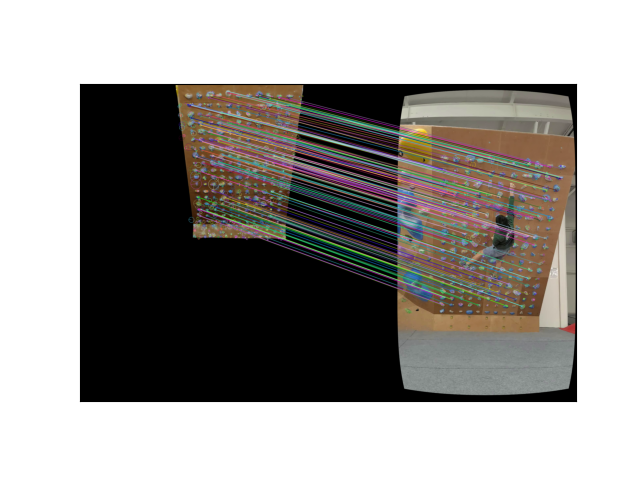

In [26]:
fig, ax = plt.subplots()
_img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
ax.imshow(_img3)
ax.set_xticks([])
ax.set_yticks([])

In [27]:
# Coordinates of the keypoints in reference and target images
pt1 = np.float32([kp1[m.queryIdx].pt for m in matches_plane])
pt2 = np.float32([kp2[m.trainIdx].pt for m in matches_plane])

Find 3D Coordinates of the Matching Points on the 3D Mesh Model

Compute the mesh & ray intersection points

In [28]:
pts_img, pts_wld = get_pair_2d_3d(pt1, pt2, scn, cam_obj0, K_blender)

Visualise the 3D Coords of the feature points

Text(0.5, 0, 'Z')

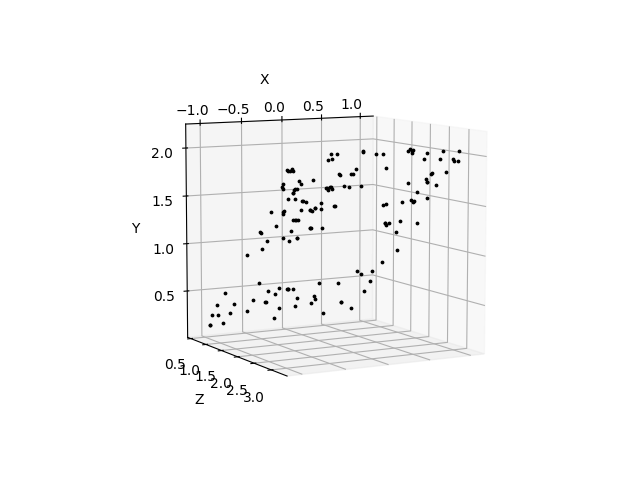

In [29]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_aspect('equal')
for coords in pts_wld:
    x, y, z = coords
    ax.scatter(x, y, z, c='black', s=3)
ax.view_init(elev=60, azim=164, roll=-104)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Computing the rotation & translation vectors for the 3D corrds to the 2D coords projection

In [30]:
rvec_wall, tvec_wall = solvePnP(pts_wld, pts_img, cameradata)
rvec_wall, tvec_wall

(array([[     2.7417],
        [   0.056848],
        [    0.10089]]),
 array([[  -0.028174],
        [     1.8156],
        [     5.7157]]))

In [31]:
r, theta, height = 8, 0, 1.7
rvec_render = cam_position2rvec(theta)
tvec_render = cylindrical2cartesian(r, theta, height, vector_fmt=True)
T_wall_rendering = get_extrinsic_matrix(rvec_render, tvec_render)
T_wall_rendering_inv = np.linalg.inv(T_wall_rendering)

In [32]:
T_wall = get_extrinsic_matrix(rvec_wall, tvec_wall)
T_wall_inv = np.linalg.inv(T_wall)

# Later work ...
 !Theoretical configuration of holds. Need to kow the exact rvec and tvec to the rendered image in blender to make it work!

In [33]:
# import pickle
# import os
# class Holds:
#     """
#     Get coordinates of all the holds projected to the video frame from the rotayion & translation matrix and the 3d coordinates of the holds
#     coords_world: 3d coordinates of all the holds used for solving PnP
#     rvec: Rotation vector
#     tvec: Translation vector
#     camera: CameraData instance
#     """
#     def __init__(self, **kwargs):
#         # wold coordinates of the holds
#         self.path_coords_holds = os.path.join('C:/Users/xxx/Desktop', 'world_coords_holds.pkl')
#         self.cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
#         self.col_colours = ['brown', 'red', 'moccasin', 'orange', 'yellow', 'green', 'darkcyan', 'blue', 'blueviolet', 'purple', 'pink']
#         self.colour_dict = {k: c for k, c in zip(self.cols, self.col_colours)}

#         if not os.path.exists(self.path_coords_holds):
#             self.init_nodes(**kwargs)
#         else:
#             self.coords_world = pickle.load(open(self.path_coords_holds, 'rb'))
#         self.rvec = kwargs.pop('rvec', None)
#         self.tvec = kwargs.pop('tvec', None)
#         self.camera = kwargs.pop('camera', None)  # CameraData instance
#         self.K = self.camera.intrinsic_matrix
#         self.dist = self.camera.distortion_coeff

#     def init_nodes(self, **kwargs):
#         """
#         Inititialise the node attributes
#         """
#         self.coords_world = {}
#         inverty = kwargs.pop('inverty', False)
#         self.wall_angle = 40 # degrees
#         theta = self.wall_angle / 180 * np.pi

#         y0 = 100 * np.cos(theta) + 370
#         z0 = 100 * np.sin(theta)
#         for col in self.cols:
#             for row in range(1,19):
#                 # Centred on column F
#                 xx = (self.cols.index(col) - 5) * 200
#                 yy = y0 + 200 * np.cos(theta) * (row - 1)
#                 # zz = z0 + 200 * np.sin(theta) * (row - 1)
#                 zz = -(z0 + 200 * np.sin(theta) * (row - 1))
#                 if inverty:
#                     yy = -1 * yy
#                 # self.coords_world[col + str(row)] = (xx, yy, zz)
#                 self.coords_world[col + str(row)] = (xx*1e-3, yy*1e-3, zz*1e-3)  # mm to m

#         pickle.dump(self.coords_world, open(self.path_coords_holds, 'wb'))

#     def get_projection(self):
#         """
#         Get the projection of the holds world coordinates to the video perspective
#         """
#         # Map the 3D point to 2D point
#         world_coords = np.array(list(self.coords_world.values())).astype('float32')
#         coords_2d, _ = cv2.projectPoints(world_coords, 
#                                         self.rvec, self.tvec, 
#                                         self.K, 
#                                         self.dist)
#         self.coords_frame = {k: v for k, v in zip(self.coords_world.keys(), coords_2d)}
#         return self.coords_frame


In [34]:
# kwargs = {
#     'inverty': True,
#     'rvec': rvec_wall,
#     'tvec': tvec_wall, 
#     'camera': cameradata,
# }
# holds = Holds(**kwargs)

In [35]:
# fig, ax = plt.subplots()
# # ax.imshow(img2)
# ax.set_aspect('equal')
# for k, v in holds.coords_world.items():
#     xx, yy, zz, _ = T_wall @ T_wall_rendering @ [v[0], v[1], v[2], 1]
#     # xxx, yyy, zzz, _ = T_wall_inv @ [xx, yy, zz, 1]
#     # ax.scatter(xxx, yyy, zzz, label=k, s=1)
#     ax.scatter(xx, yy, label=k, s=1, c=holds.colour_dict[k[0]])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')

# Human Pose Estimation

#  Repeat the Analysis for Each Frames of the submitted video

- Get the initial guess of the rendering angle
- Sample parameters -> Maximise the number of matching points
- Get the full tvec and rvec from the mesh model to the scene
- Get the 3D human pose coordinates adjusteds

SolvePnP for 3D and 2D human pose pair

In [36]:
def mediapipe_3d2d_solvePnP(humanpose: HumanPose, t: int):
    """
    Obtain Mediappipe 3d pose -> 2d pose projection tvec & tvec at frame t
    """
    rvec, tvec = solvePnP(humanpose.coords3d[t], humanpose.coords2d[t], cameradata)
    return rvec, tvec

In [37]:
rvec_mp2img, tvec_mp2img = mediapipe_3d2d_solvePnP(pose_mp, frame_number)

In [38]:
T_mp2img = get_extrinsic_matrix(rvec_mp2img, tvec_mp2img)
T_mp2img_inv = np.linalg.inv(T_mp2img)

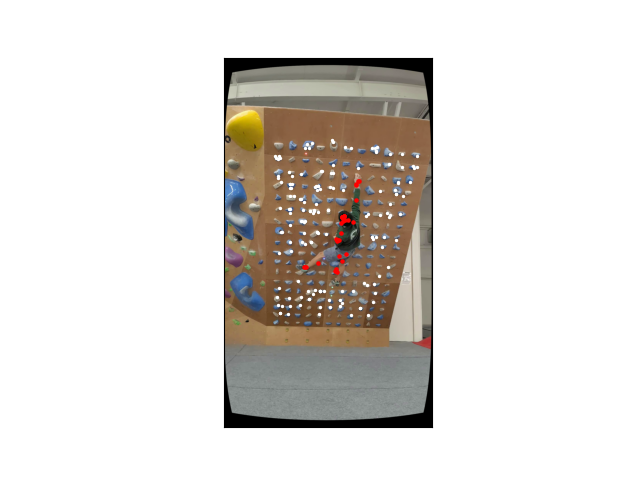

In [39]:
pose2d_projection, _ = cv2.projectPoints(
    pose_mp.coords3d[frame_number],
    rvec_mp2img, tvec_mp2img,
    cameradata.intrinsic_matrix,
    np.array(cameradata.distortion_coeff)
    )

holds2d_projection, _ = cv2.projectPoints(
    pts_wld,
    rvec_wall, tvec_wall,
    cameradata.intrinsic_matrix,
    np.array(cameradata.distortion_coeff)
    )

fig, ax = plt.subplots()
_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
ax.imshow(_img2)
for i in range(pose2d_projection.shape[0]):
    ax.scatter(*pose2d_projection[i][0], c='red', s=5)

for i in range(holds2d_projection.shape[0]):
    ax.scatter(*holds2d_projection[i][0], c='white', s=2)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [40]:
pose_global = coords_transformation_3D(pose_mp.coords3d[frame_number], [T_mp2img, T_wall_inv])

Text(0.5, 0, 'Z')

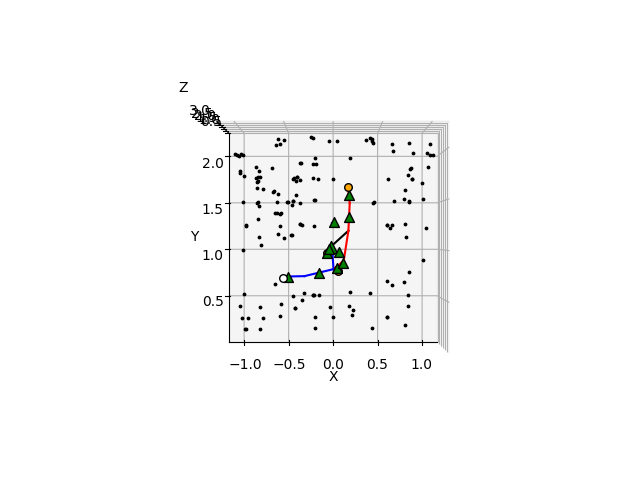

In [41]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_aspect('equal')

body = Body(
    weight,
    frame_number,
    pose_mp.coords2d[frame_number],
    pose_global,
    pose_mp.coords2d_confidence[frame_number],
    pose_mp.coords3d_confidence[frame_number],
    videodata.path.replace('mp4', 'pkl')
    )
body.plot(ax)

for coords in pts_wld:
    x, y, z = coords
    ax.scatter(x, y, z, c='black', s=3)

# ax.view_init(elev=60, azim=164, roll=-104)
# ax.view_init(elev=0, azim=180, roll=-90)
# ax.view_init(elev=0, azim=0, roll=90)
ax.view_init(elev=90, azim=-90, roll=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot_3d(
#     plane.plotter(alpha=0.2, lims_x=(-300, 300), lims_y=(-300, 300)),
# )

Get contact info and adjust the coorddinates

In [42]:
contacts2d = body.contact_points2d
contacts3d = body.contact_points3d

In [43]:
def contactpoints_calibration(body: Body, perspective_transformation, scene, cam_obj, K_blender, *args):
    plot = False
    if len(args) == 2:
        plot = True
        img1, img2 = args

    contacts2d = body.contact_points2d
    contacts3d = body.contact_points3d

    coords3d_notcalibrated = []
    coords3d_contact = []

    if plot:
        plt.ion()
        fig, axes = plt.subplots(1,2)
        _img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        _img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        axes[0].imshow(_img1)
        axes[1].imshow(_img2)

    contacts2d_dict = contacts2d.dict_points
    contacts3d_dict = contacts3d.dict_points

    for part in contacts3d.dict_points.keys():
        if (contacts3d_dict[part]['state'] == 1) and (contacts3d_dict[part]['conf'] > 0.5):
            point_to_project = np.array([contacts2d_dict[part]['coords']], dtype='float32').reshape(-1, 1, 2)
            projected_point = cv2.perspectiveTransform(point_to_project, np.linalg.inv(perspective_transformation))[0]
            if plot:
                axes[0].scatter(*projected_point[0], c='white', s=2)
                axes[1].scatter(*point_to_project[0][0], c='white', s=2)

            print("Projected Contact Point (conf>50%):", projected_point[0])
            p2d, p3d = get_pair_2d_3d(projected_point, point_to_project[0], scene, cam_obj, K_blender)
            coords3d_notcalibrated.append(contacts3d_dict[part]['coords'])
            coords3d_contact.append(p3d[0])
    return coords3d_notcalibrated, coords3d_contact

Update the pose 3d coords

Projected Contact Point (conf>50%): [     1021.5      222.95]
Projected Contact Point (conf>50%): [     1007.7      639.42]


[array([    0.15286,      1.6261,      2.9481]),
 array([   0.050409,     0.77864,      1.5055])]

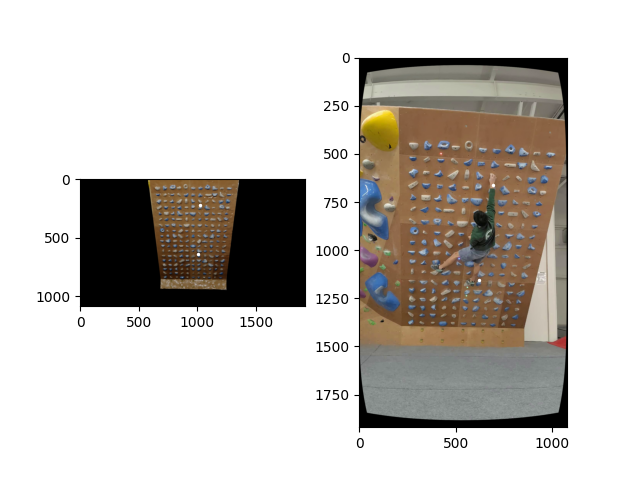

In [44]:
coords3d_notcalibrated, coords3d_contact = contactpoints_calibration(body, perspective_transformation, scn, cam_obj0, K_blender, img1, img2)
coords3d_notcalibrated

In [45]:
# Projected pose


# Coordinates in video frame image - Coordinates in the model perspective transformation
H_img2model, mask = cv2.findHomography(
    pts_img,
    np.array([pts_wld[i][:2] for i in range(pts_wld.shape[0])]),
    cv2.RANSAC,
    5.0
    )

pose_wallmodel_projection = cv2.perspectiveTransform(pose2d_projection, H_img2model)
# The pose on video frame is transformed to the model X-Y plane coordinates assuming that the feature points and the pose are on the same plane, which is not quite true ...


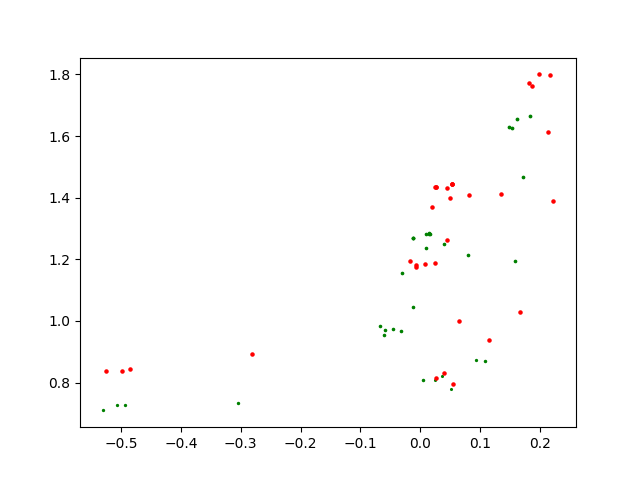

In [46]:


fig, ax = plt.subplots()
for i in range(pose_global.shape[0]):
    ax.scatter(*pose_global[i], c='green')

# pose2d_on_rendered_img = []
pose2d_video = np.array(pose_mp.coords2d[frame_number], dtype='float32').reshape(-1, 1, 2)
pose2d_render = cv2.perspectiveTransform(pose2d_video, np.linalg.inv(perspective_transformation))
for i in range(pose2d_render.shape[0]):
    ax.scatter(*pose_wallmodel_projection[i][0], s=5, c='red')
    # pose2d_on_rendered_img.append(pose2d_render[i][0])
plt.show()

In [47]:
def plane_fit(points3d):
    """
    Fit a plane: z = ax + by + c
    points3d: (N, 3) array of wall 3D points
    Returns: coefficients (a, b, c)
    """
    X = points3d[:, :2]  # x, y
    z = points3d[:, 2]   # z
    model = LinearRegression()
    model.fit(X, z)
    a, b = model.coef_
    c = model.intercept_
    return a, b, c

def get_wall_z(x, y, a, b, c):
    return a * x + b * y + c

In [48]:
def pose_scale_changer(coords, scale):
    coords_mean = np.mean(coords, axis=0)
    return coords_mean + (coords - coords_mean) * scale

In [49]:
def loss_with_scale(params, A_known, B_known, A_all, B_proj, weights, plane_coeffs, verbose=False):
    if len(weights) != 3:
        weights = [1,1,1]
    rvec = params[:3].reshape((3, 1))
    tvec = params[3:6].reshape((3, 1))
    scale = params[6]

    # Scale input poses
    A_known_scaled = pose_scale_changer(A_known, scale)
    A_all_scaled = pose_scale_changer(A_all, scale)

    # Transform known 3D points
    T = get_extrinsic_matrix(rvec, tvec)
    A_known_h = np.hstack([A_known_scaled, np.ones((A_known.shape[0], 1))])
    A_known_trans = (T @ A_known_h.T).T[:, :3]
    loss_3d = np.mean(np.linalg.norm(A_known_trans - B_known, axis=1)**2)

    # Compare the xy coordinates
    A_proj = A_all_scaled[:,:2]

    A_proj = A_proj.squeeze()
    loss_2d = np.mean(np.linalg.norm(A_proj - B_proj, axis=1)**2)

    # Wall constraint: penalize Z < wall_z
    A_all_h = np.hstack([A_all_scaled, np.ones((A_all_scaled.shape[0], 1))])
    A_all_trans = (T @ A_all_h.T).T[:, :3]

    if plane_coeffs is not None:
        x, y, z = A_all_trans[:, 0], A_all_trans[:, 1], A_all_trans[:, 2]
        z_wall = get_wall_z(x, y, *plane_coeffs)
        wall_violations = np.clip(z_wall - z, 0, None)  # Only penalize if below wall
        loss_wall = np.mean(wall_violations**2)
    else:
        loss_wall = 0

    scale_3d = np.mean(np.linalg.norm(B_known, axis=1)) + 1e-6
    scale_2d = np.mean(np.linalg.norm(B_proj, axis=1)) + 1e-6
    scale_wall = np.mean(np.abs(A_all_trans[:, 2])) + 1e-6

    loss_3d_std = loss_3d / (scale_3d ** 2)
    loss_2d_std = loss_2d / (scale_2d ** 2)
    loss_wall_std = loss_wall / (scale_wall ** 2)

    loss = weights[0] * loss_3d_std + weights[1] * loss_2d_std + weights[2] * loss_wall_std
    if verbose:
        print(f'total loss: {loss:.3f}, 3d: {loss_3d_std:.3f}, 2d: {loss_2d_std:.3f}, wall: {loss_wall_std:.3f}')
    return loss


In [50]:
A_known = np.array(coords3d_notcalibrated)
B_known = np.array(coords3d_contact)
A_all = np.array(pose_mp.coords3d[frame_number])
B_proj = np.array(pose_wallmodel_projection.reshape(-1, 2))

In [51]:
init_params = np.zeros(7)
init_params[6] = 1
weights = [8, 6, 8]
plane_coeffs = plane_fit(pts_wld)
rvec_bounds = [(-np.pi/8, np.pi/8)] * 3
tvec_bounds = [(None, None)] * 3
scale_bounds = [(0.85, 1.15)]
camera_rendering = {
    'intrinsic_matrix': K_blender,
    'distortion_coeff': [0, 0, 0, 0, 0]
    }


res = minimize(
    loss_with_scale, init_params,
    args=(A_known, B_known, A_all, B_proj, weights, plane_coeffs),
    method='L-BFGS-B',
    bounds=rvec_bounds + tvec_bounds + scale_bounds
)

rvec_opt = res.x[:3].reshape(3, 1)
tvec_opt = res.x[3:6].reshape(3, 1)
scale_opt = res.x[6]
T_opt = get_extrinsic_matrix(rvec_opt, tvec_opt)
pose_global_calibrated = coords_transformation_3D(pose_scale_changer(pose_global, scale_opt), [T_opt,])

Add constraint

- projection of the transformed pose in video frame perspective should not be too different fromt that of the 2D pose detected
- z coordinate of the contact point should be on the wall if the confidence level is higher than the threshold
- any pose keypoint cannot penetrate the wall


In [52]:
def get_xyz_lims(pts_wld):
    ax_limits = []
    xyz_minmax = []
    for i in range(3):
        pmin = min(pts_wld[:,i])
        pmax = max(pts_wld[:,i])
        pmergine = 0.15 * (pmax - pmin)
        ax_limits.append([pmin-pmergine, pmax+pmergine])
        xyz_minmax.append([pmin, pmax])
    # xlim, ylim, zlim = ax_limits
    return ax_limits, xyz_minmax

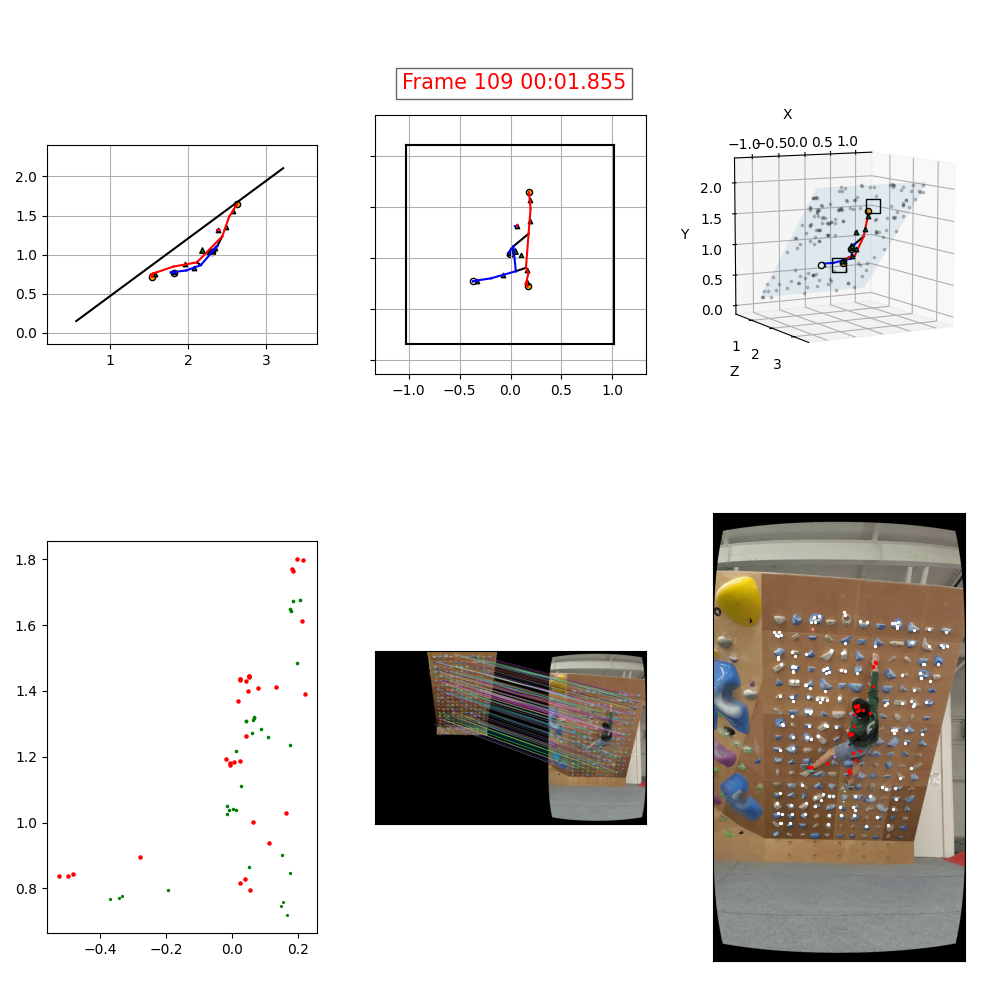

In [53]:
body = Body(
    weight,
    frame_number,
    pose_mp.coords2d[frame_number],
    pose_global_calibrated,
    pose_mp.coords2d_confidence[frame_number],
    pose_mp.coords3d_confidence[frame_number],
    videodata.path.replace('mp4', 'pkl')
    )

plt.ion()
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.view_init(elev=60, azim=164, roll=-104)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)
ax3d = [ax3]
ax2d = [ax1, ax2, ax4, ax5, ax6]
plt.tight_layout()

plt.setp(ax2.get_yticklabels(), visible=False)

ax_limits, xyz_minmax = get_xyz_lims(pts_wld)
xlim, ylim, zlim = ax_limits

for ax in ax3d+ax2d:
    ax.set_aspect('equal')


for ax in ax3d:
    ax.set_xlim3d(*xlim)
    ax.set_ylim3d(*ylim)
    ax.set_zlim3d(*zlim)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # Plane
    xx, yy = np.meshgrid(xyz_minmax[0], xyz_minmax[1])
    z = get_wall_z(xx, yy, *plane_coeffs)
    ax.plot_surface(xx, yy, z, alpha=0.1)

    body.plot(ax, size_contact=20, size_com=10, dimensions='3d')
    for coords in pts_wld:
        x, y, z = coords
        ax.scatter(x, y, z, c='black', s=3, alpha=0.2)
    for pt in coords3d_contact:
        ax.scatter(*pt, marker='s', edgecolors='black', facecolors='none', s=100, linewidths=1)

ax1.set_xlim(*zlim)
ax1.set_ylim(*ylim)
ax1.grid()
ax2.set_xlim(*xlim)
ax2.set_ylim(*ylim)
ax2.grid()

plane_coeffs = plane_fit(pts_wld)
xx, yy = np.meshgrid(xyz_minmax[0], xyz_minmax[1])
z = get_wall_z(xx, yy, *plane_coeffs)

corners_zy = np.column_stack((z.flatten(), yy.flatten()))
ax1.plot(*np.column_stack((corners_zy[3].flatten(), corners_zy[1].flatten())), c='black')

corners_xy = np.column_stack((xx.flatten(), yy.flatten()))
ax2.plot(*np.column_stack((corners_xy[0].flatten(), corners_xy[1].flatten())), c='black')
ax2.plot(*np.column_stack((corners_xy[3].flatten(), corners_xy[1].flatten())), c='black')
ax2.plot(*np.column_stack((corners_xy[0].flatten(), corners_xy[2].flatten())), c='black')
ax2.plot(*np.column_stack((corners_xy[2].flatten(), corners_xy[3].flatten())), c='black')



body.plot(ax1, size_contact=20, size_com=10, dimensions='zy')
body.plot(ax2, size_contact=20, size_com=10, dimensions='xy')

for ax in [ax5, ax6]:
    ax.set_xticks([])
    ax.set_yticks([])

_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
_img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
ax5.imshow(_img3)
ax6.imshow(_img2)
for i in range(pose2d_projection.shape[0]):
    ax6.scatter(*pose2d_projection[i][0], s=2, c='red')
    ax4.scatter(*pose_global_calibrated[i], c='green')
    ax4.scatter(*pose_wallmodel_projection[i][0], s=5, c='red')

for i in range(holds2d_projection.shape[0]):
    ax6.scatter(*holds2d_projection[i][0], c='white', s=2)

ax2.text(0.1, 1.1, f"Frame {frame_number} {frame_to_timestamp(frame_number, videodata.fps)}", transform=ax2.transAxes,
            fontsize=15, color='red', bbox=dict(facecolor='white', alpha=0.6))
# ax1.set_xticks([])
# ax1.set_xlabel('')
# ax2.set_zticks([])
# ax2.set_zlabel('')
plt.ioff()

# Iterate the routine through the whole video

## More work on the rendering angle optimisation for the case camera is moving ...

In [54]:
videodata_new = VideoData(video_path)
videodata_copy = VideoData(video_path)
# pose_mp = videodata_copy.get_human_pose()
del videodata_copy

In [55]:
# Pre-compute the coordinates for all the frames


def frame_analysis(frame_number):
    """
    Actual Computation
    """
    # videodata = VideoData(video_path)
    # cameradata = CameraData(cam_json)
    img2 = cv2.undistort(videodata.load_frame(frame_number), cameradata.intrinsic_matrix, cameradata.distortion_coeff)
    img1_processed, img2_processed = images_preprocessing(img1, img2)

    kp1, kp2, matches_good = featurepoint_matching(img1_processed, img2_processed, masks[frame_number])
    kp1, kp2, matches_plane, perspective_transformation = featurepoint_matching_homography(kp1, kp2, matches_good)

    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches_plane, None, matchesThickness=2, flags=2)

    # Coordinates of the keypoints in reference and target images
    pt1 = np.float32([kp1[m.queryIdx].pt for m in matches_plane])
    pt2 = np.float32([kp2[m.trainIdx].pt for m in matches_plane])

    
    pts_img, pts_wld = get_pair_2d_3d(pt1, pt2, scn, cam_obj0, K_blender)

    rvec_wall, tvec_wall = solvePnP(pts_wld, pts_img, cameradata)

    r, theta, height = 8, 0, 1.7
    rvec_render = cam_position2rvec(theta)
    tvec_render = cylindrical2cartesian(r, theta, height, vector_fmt=True)
    T_wall_rendering = get_extrinsic_matrix(rvec_render, tvec_render)
    T_wall_rendering_inv = np.linalg.inv(T_wall_rendering)

    T_wall = get_extrinsic_matrix(rvec_wall, tvec_wall)
    T_wall_inv = np.linalg.inv(T_wall)

    rvec_mp2img, tvec_mp2img = mediapipe_3d2d_solvePnP(pose_mp, frame_number)
    T_mp2img = get_extrinsic_matrix(rvec_mp2img, tvec_mp2img)

    pose2d_projection, _ = cv2.projectPoints(
        pose_mp.coords3d[frame_number],
        rvec_mp2img, tvec_mp2img,
        cameradata.intrinsic_matrix,
        np.array(cameradata.distortion_coeff)
        )

    pose_global = coords_transformation_3D(pose_mp.coords3d[frame_number], [T_mp2img, T_wall_inv])
    body = Body(
        weight,
        frame_number,
        pose_mp.coords2d[frame_number],
        pose_global,
        pose_mp.coords2d_confidence[frame_number],
        pose_mp.coords3d_confidence[frame_number],
        videodata.path.replace('mp4', 'pkl')
        )
    
    # Try to match the 3d coordinates of the contact points if the confidence of the detection is above the threshold
    conf_threshold = 0.5
    contacts2d = body.contact_points2d
    contacts3d = body.contact_points3d
    coords3d_notcalibrated = []
    coords3d_contact = []
    contacts2d_dict = contacts2d.dict_points
    contacts3d_dict = contacts3d.dict_points
    for part in contacts3d.dict_points.keys():
        if (contacts3d_dict[part]['state'] == 1) and (contacts3d_dict[part]['conf'] > conf_threshold):
            # Projection of the point in video frame to the rendered image
            point_to_project = np.array([contacts2d_dict[part]['coords']], dtype='float32').reshape(-1, 1, 2)
            projected_point = cv2.perspectiveTransform(point_to_project, np.linalg.inv(perspective_transformation))[0]
            p2d, p3d = get_pair_2d_3d(projected_point, point_to_project[0], scn, cam_obj0, K_blender)
            
            coords3d_notcalibrated.append(contacts3d_dict[part]['coords'])
            coords3d_contact.append(p3d[0])

    if len(coords3d_contact) > 0:
        # Optimisation
        # geature points coordinates in video frame image - Coordinates in the model perspective transformation
        H_img2model, _ = cv2.findHomography(
            pts_img,
            np.array([pts_wld[i][:2] for i in range(pts_wld.shape[0])]),
            cv2.RANSAC,
            5.0
            )

        pose_wallmodel_projection = cv2.perspectiveTransform(pose2d_projection, H_img2model)
        # The pose on video frame is transformed to the model X-Y plane coordinates assuming that the feature points and the pose are on the same plane, which is not quite true ...
        A_known = np.array(coords3d_notcalibrated)
        B_known = np.array(coords3d_contact)
        A_all = np.array(pose_mp.coords3d[frame_number])
        B_proj = np.array(pose_wallmodel_projection.reshape(-1, 2))

        init_params = np.zeros(7)
        init_params[6] = 1
        weights = [8, 7, 7]
        plane_coeffs = plane_fit(pts_wld)
        rvec_bounds = [(-np.pi/6, np.pi/6)] * 3
        tvec_bounds = [(None, None)] * 3
        scale_bounds = [(0.85, 1.15)]

        res = minimize(
            loss_with_scale, init_params,
            args=(A_known, B_known, A_all, B_proj, weights, plane_coeffs),
            method='L-BFGS-B',
            bounds=rvec_bounds + tvec_bounds + scale_bounds
        )

        rvec_opt = res.x[:3].reshape(3, 1)
        tvec_opt = res.x[3:6].reshape(3, 1)
        scale_opt = res.x[6]
        print(f'R: {rvec_opt} | T: {tvec_opt} | S: {scale_opt}')
        T_opt = get_extrinsic_matrix(rvec_opt, tvec_opt)
        pose_global_calibrated = coords_transformation_3D(pose_scale_changer(pose_global, scale_opt), [T_opt,])







    else:
        pose_global_calibrated = pose_global

    # Visualise the results
    body_adjusted = Body(
        weight,
        frame_number,
        pose_mp.coords2d[frame_number],
        pose_global_calibrated,
        pose_mp.coords2d_confidence[frame_number],
        pose_mp.coords3d_confidence[frame_number],
        videodata.path.replace('mp4', 'pkl')
        )

    holds2d_projection, _ = cv2.projectPoints(
        pts_wld,
        rvec_wall, tvec_wall,
        cameradata.intrinsic_matrix,
        np.array(cameradata.distortion_coeff)
        )

    return body_adjusted, coords3d_contact, pts_wld, img2, img3, pose2d_projection, holds2d_projection

preprocessing took 15 minutes before, now 9 min 16 sec with 46 sec preprocess by yolo

In [56]:
L_body_adjusted = []
L_coords3d_contact = []
L_pts_wld = []
L_img2 = []
L_img3 = []
L_pose2d_projection = []
L_holds2d_projection = []

for frame_number in range(videodata.total_frames):
    body_adjusted, coords3d_contact, pts_wld, img2, img3, pose2d_projection, holds2d_projection = frame_analysis(frame_number)
    L_body_adjusted.append(body_adjusted)
    L_coords3d_contact.append(coords3d_contact)
    L_pts_wld.append(pts_wld)
    L_img2.append(img2)
    L_img3.append(img3)
    L_pose2d_projection.append(pose2d_projection)
    L_holds2d_projection.append(holds2d_projection)

R: [[   -0.29633]
 [   -0.46972]
 [   -0.30973]] | T: [[    0.28596]
 [   -0.66512]
 [    0.63862]] | S: 0.85
R: [[   -0.38569]
 [   -0.14799]
 [    0.20573]] | T: [[    0.60784]
 [   -0.71627]
 [    0.61631]] | S: 0.85
R: [[   -0.36297]
 [   -0.17031]
 [  -0.031283]] | T: [[     0.2519]
 [   -0.70265]
 [    0.63446]] | S: 0.85
R: [[    -0.3436]
 [   -0.19677]
 [   -0.17133]] | T: [[   0.055291]
 [   -0.67636]
 [    0.56586]] | S: 0.85
R: [[   -0.28695]
 [    -0.1394]
 [   -0.06484]] | T: [[   0.071436]
 [   -0.61361]
 [    0.71183]] | S: 0.85
R: [[   -0.33753]
 [  0.0039532]
 [  0.0081916]] | T: [[  -0.012377]
 [   -0.66425]
 [    0.62312]] | S: 0.85
R: [[   -0.37211]
 [  -0.074744]
 [   -0.11804]] | T: [[  -0.058311]
 [   -0.70736]
 [    0.59288]] | S: 0.85
R: [[    -0.2191]
 [  -0.075904]
 [  0.0042821]] | T: [[   0.034932]
 [   -0.54956]
 [    0.80587]] | S: 0.85
R: [[   -0.33989]
 [   -0.51399]
 [   -0.33842]] | T: [[    0.24691]
 [   -0.69992]
 [     0.7301]] | S: 0.85
R: [[   -0

# Coordinates data smoothing

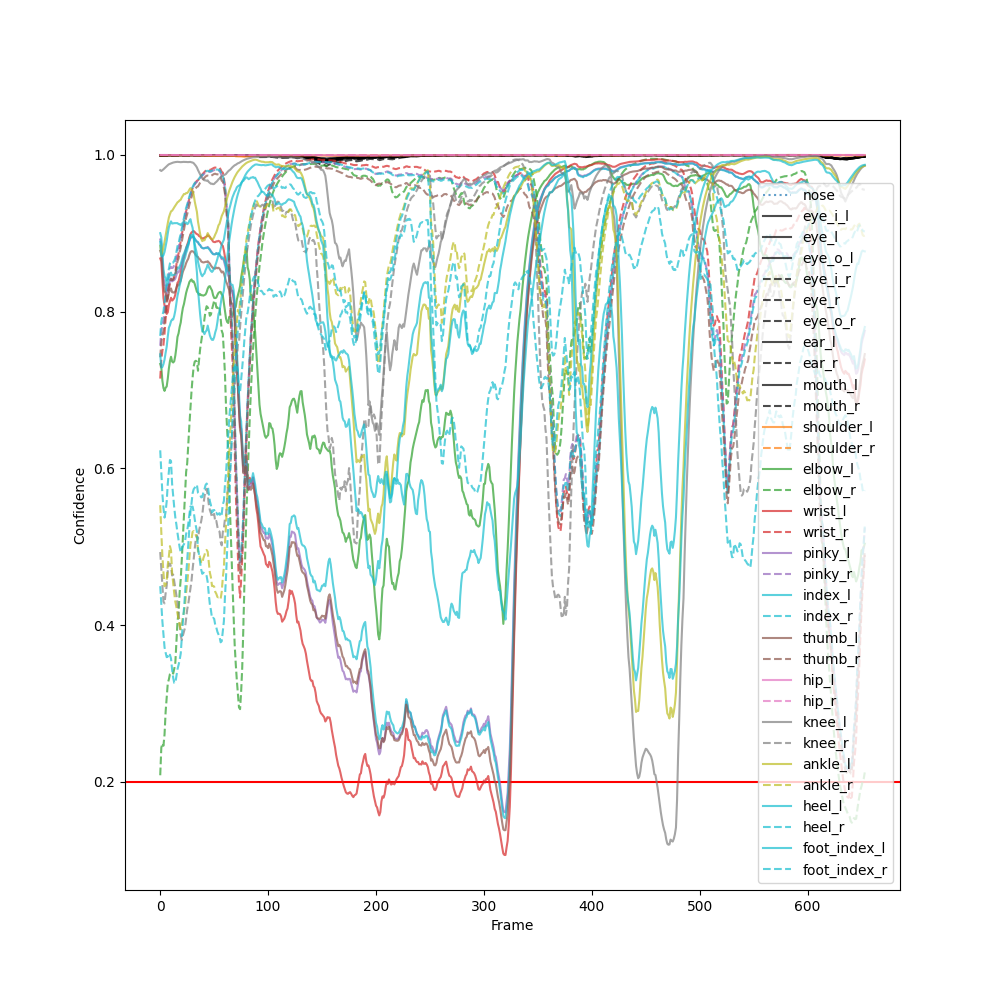

In [57]:
conf_threshold = 0.2
# kp_head_ignore = ['eye_i_l', 'eye_i_r', 'eye_l', 'eye_r', 'eye_o_l', 'eye_o_r', 'ear_l', 'ear_r', 'mouth_l', 'mouth_r']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Frame')
ax.set_ylabel('Confidence')
ax.axhline(y=conf_threshold, c='red')

conf = np.array([L_body_adjusted[i].coords3d_confidence for i in range(len(L_body_adjusted))])
coords = np.array([L_body_adjusted[i].coords3d for i in range(len(L_body_adjusted))])

for kp in KEYPOINTS:
    _conf = conf[:, get_kp_idx(kp)]
    # Section where the conf < conf_threshold
    idx = np.where(_conf < conf_threshold)[0]
    for i in idx:
        if i != 0:
            coords[i, get_kp_idx(kp), :] = np.nan

    c, ls = get_plot_style(kp)
    ax.plot(_conf, label=kp, c=c, ls=ls, alpha=0.7)

# ax.axvspan(a, b, color='gray', alpha=0.5, lw=0)

ax.legend()
plt.show()

In [58]:
df_x = pd.DataFrame()
df_y = pd.DataFrame()
df_z = pd.DataFrame()
for kp in KEYPOINTS:
    df_x[kp] = coords[:,get_kp_idx(kp),0]
    df_y[kp] = coords[:,get_kp_idx(kp),1]
    df_z[kp] = coords[:,get_kp_idx(kp),2]
df_x

nose   eye_i_l     eye_l   eye_o_l   eye_i_r     eye_r   eye_o_r  \
0   -0.022480 -0.054485 -0.053891 -0.054163 -0.025273 -0.025105 -0.025100   
1    0.232442  0.196217  0.196607  0.196117  0.223232  0.223251  0.222620   
2    0.136808  0.103343  0.103827  0.103359  0.130427  0.130565  0.130162   
3    0.077979  0.047919  0.048460  0.048038  0.073961  0.074161  0.073945   
4    0.141326  0.112661  0.113121  0.112654  0.138025  0.138282  0.137945   
..        ...       ...       ...       ...       ...       ...       ...   
649 -0.344359 -0.370764 -0.370793 -0.371146 -0.344985 -0.344924 -0.345697   
650 -0.375185 -0.402053 -0.402020 -0.402404 -0.375516 -0.375503 -0.376179   
651 -0.378832 -0.407730 -0.407691 -0.408057 -0.380485 -0.380519 -0.381099   
652 -0.378719 -0.407137 -0.407109 -0.407464 -0.380228 -0.380236 -0.380845   
653 -0.333467 -0.355406 -0.355560 -0.355816 -0.331609 -0.331515 -0.332398   

        ear_l     ear_r   mouth_l  ...     hip_l     hip_r    knee_l  \
0   -0.132506 -0.022072 -0.044176  ... -0.202108 -0.040524 -0.275095   
1    0.158421  0.264431  0.230068  ...  0.306091  0.447848  0.133490   
2    0.049399  0.156213  0.126449  ...  0.090772  0.243221 -0.079500   
3   -0.013182  0.088040  0.062566  ... -0.049676  0.108332 -0.208116   
4    0.064667  0.164134  0.131182  ...  0.053149  0.207229 -0.133464   
..        ...       ...       ...  ...       ...       ...       ...   
649 -0.379151 -0.270380 -0.338923  ... -0.179056 -0.082103 -0.046477   
650 -0.419091 -0.308707 -0.372233  ... -0.243931 -0.145022 -0.110357   
651 -0.435144 -0.322304 -0.380948  ... -0.281845 -0.181508 -0.142863   
652 -0.431616 -0.319853 -0.379932  ... -0.279982 -0.180345 -0.138809   
653 -0.350167 -0.248182 -0.323302  ... -0.130467 -0.045314  0.015620   

       knee_r   ankle_l   ankle_r    heel_l    heel_r  foot_index_l  \
0    0.110648 -0.165442  0.169963 -0.146660  0.174450     -0.150465   
1    0.483790  0.327262  0.599635  0.353722  0.607282      0.355332   
2    0.334881  0.079975  0.426429  0.104125  0.431314      0.097580   
3    0.230060 -0.077538  0.296251 -0.056619  0.297527     -0.078047   
4    0.293471  0.005484  0.360384  0.027177  0.362515      0.003645   
..        ...       ...       ...       ...       ...           ...   
649  0.025888  0.180662  0.076078  0.212709  0.078493      0.256848   
650 -0.014154  0.121661  0.043260  0.154092  0.046459      0.198848   
651 -0.031989  0.088773  0.037979  0.121789  0.042585      0.166428   
652 -0.032646  0.087637  0.046979  0.120119  0.052668      0.164510   
653  0.018294  0.224470  0.083040  0.253941  0.088119      0.293954   

     foot_index_r  
0        0.217501  
1        0.647863  
2        0.476763  
3        0.331468  
4        0.391225  
..            ...  
649      0.112451  
650      0.083294  
651      0.087811  
652      0.096021  
653      0.114526  

[654 rows x 33 columns]

In [59]:
df_interp_x = df_x.interpolate(method='linear', limit_direction='both')
df_interp_y = df_y.interpolate(method='linear', limit_direction='both')
df_interp_z = df_z.interpolate(method='linear', limit_direction='both')

# Back to NumPy if needed
filled_coords_x = df_interp_x.to_numpy()
filled_coords_y = df_interp_y.to_numpy()
filled_coords_z = df_interp_z.to_numpy()

In [60]:
filled_coords = np.zeros_like(coords)
for e, array in enumerate([filled_coords_x, filled_coords_y, filled_coords_z]):
    filled_coords[:,:,e] = array

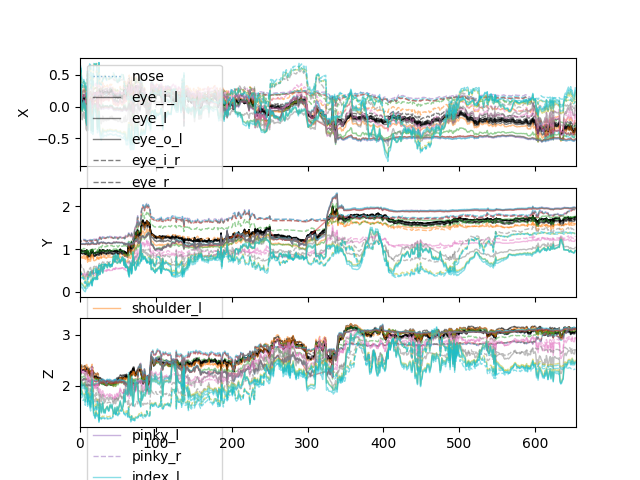

In [61]:
fig, axes = plt.subplots(3, 1, sharex=True)
# coords = np.array([L_body_adjusted[i].coords3d for i in range(len(L_body_adjusted))])
for i in range(3):

    for kp in KEYPOINTS:
        c, ls = get_plot_style(kp)
        axes[i].plot(filled_coords[:,get_kp_idx(kp),i], c=c, ls=ls, alpha=0.5, lw=1, label=kp)
    axes[i].set_ylabel(['X', 'Y', 'Z'][i])
    axes[i].set_xlim((0, videodata.total_frames))
# ax.plot(conf, alpha=0.5)
axes[0].legend()
plt.show()

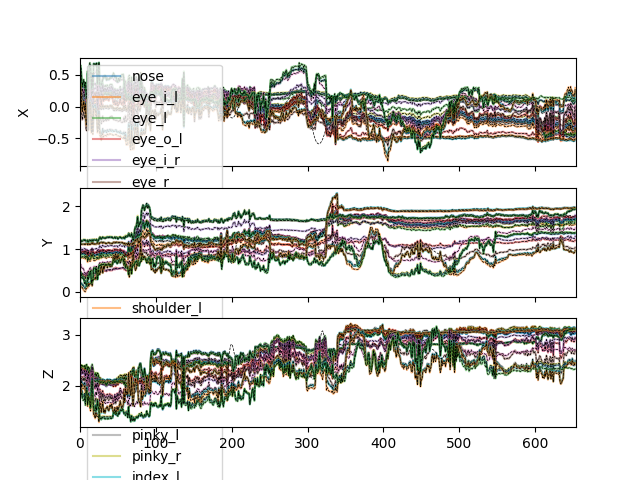

In [62]:
xs = np.arange(videodata.total_frames)
# coords_smooth = np.zeros_like(coords)
fig, axes = plt.subplots(3, 1, sharex=True)
for i in range(3):
    axes[i].set_ylabel(['X', 'Y', 'Z'][i])
    axes[i].set_xlim((0, videodata.total_frames))
    for kp in KEYPOINTS:
        # Spline fit
        ikp = get_kp_idx(kp)
        spl = spline_smoothing(xs, coords[:,ikp,i], lam=0)
        # coords_smooth[:,ikp,i] = spl(xs)
        axes[i].plot(coords[:,ikp,i], label=kp, alpha=0.5, lw=1.5)
        axes[i].plot(xs, spl(xs), '--', lw=0.5, c='black')
axes[0].legend()
plt.show()


9


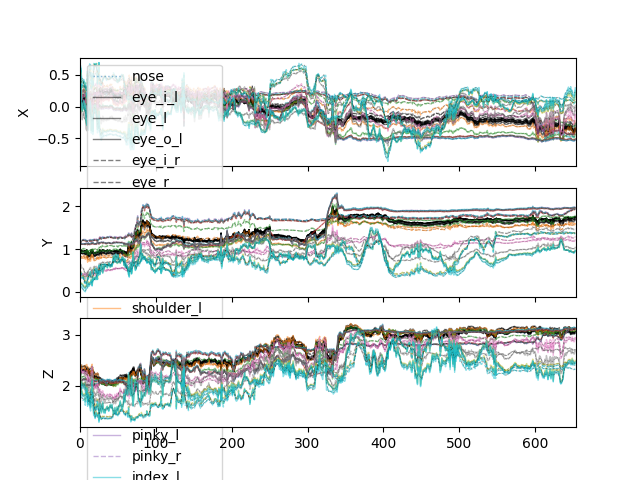

In [63]:
_w = int(videodata.fps*0.15)
window_size = _w if _w % 2 != 0 else _w + 1
# _w = 40
print(window_size)
poly_order = 2
fig, axes = plt.subplots(3, 1, sharex=True)
# coords = np.array([L_body_adjusted[i].coords3d for i in range(len(L_body_adjusted))])
list_coords_smooth = np.zeros_like(filled_coords)
for i in range(3):
    axes[i].set_ylabel(['X', 'Y', 'Z'][i])
    axes[i].set_xlim((0, videodata.total_frames))
    for kp in KEYPOINTS:
        coords_smooth = savgol_filter(filled_coords[:,get_kp_idx(kp),i], window_size, poly_order)
        list_coords_smooth[:,get_kp_idx(kp),i] = coords_smooth
        c, ls = get_plot_style(kp)
        axes[i].plot(coords_smooth, alpha=0.5, c='black', ls='--', lw=0.5)
        axes[i].plot(filled_coords[:,get_kp_idx(kp),i], c=c, ls=ls, alpha=0.5, lw=1, label=kp)
axes[0].legend()
# ax.plot(conf, alpha=0.5)
plt.show()

In [64]:
# Update the coordinates by the smooth version
for frame_number in range(videodata.total_frames):
    L_body_adjusted[frame_number].coords3d = list_coords_smooth[frame_number,:,:]

# Physical Quantities

In [65]:
parts_cols = {
    'forearm_l': "#812DEE",
    'forearm_r': "#EE2DB4",
    'arm_l': "#2D6AEE",
    'arm_r': "#2DD1EE",
    'thigh_l': "#2DEE2D",
    'thigh_r': "#EEE12D",
    'lowerleg_l': "#EE9A2D",
    'lowerleg_r': '#EE2D2D',
    'body': "#FFFD92",
    'head': "#92FFD2",
    'total': "#515568",
}

In [66]:
def dfdx(f, x):
    # https://stackoverflow.com/questions/18991408/python-finite-difference-functions
    #First derivative
    dx = x[1] - x[0]
    df = ndimage.gaussian_filter1d(f, sigma=1, order=1, mode='wrap') / dx
    return df

def d2fdx2(f, x):
    dx = x[1] - x[0]
    dx2 = dx**2
    ddf = ndimage.gaussian_filter1d(f, sigma=1, order=2, mode='wrap') / dx2
    return ddf

In [67]:
mass = L_body_adjusted[0].mass
com_parts = list(L_body_adjusted[0].dict_com3d.keys())
dict_com_mass = {}
for part in com_parts:
    name_match = set(part.split('_')) & set(mass.keys())
    if len(name_match) > 0:
        _part = list(name_match)[0]
        dict_com_mass[part] = mass[_part]

ts = np.arange(videodata.total_frames)/videodata.fps
dt = ts[1] - ts[0]

# Position
dict_coords3d_com = {
    part: np.array([body.dict_com3d[part] for body in L_body_adjusted]) for part in com_parts
}

# Velocity
dict_vel3d_com = {
    part: np.stack([dfdx(dict_coords3d_com[part][:, i], ts) for i in range(3)], axis=1) for part in com_parts
}

# Acceleration
dict_acc3d_com = {
    part: np.stack([d2fdx2(dict_coords3d_com[part][:, i], ts) for i in range(3)], axis=1) for part in com_parts
}



# Linear Momentum
dict_mtm3d_com = {
    part: np.stack([dict_com_mass[part] * dict_vel3d_com[part][:, i] for i in range(3)], axis=1) for part in com_parts
}

# 
dict_imp3d_com = {
    part: np.stack([dfdx(dict_mtm3d_com[part][:, i], ts) for i in range(3)], axis=1) for part in com_parts
}

# Clean data
for dict_quantity in [dict_vel3d_com, dict_acc3d_com, dict_mtm3d_com, dict_imp3d_com]:
    for part in com_parts:
        data = dict_quantity[part]
        data[:5,:] = np.nan
        data[-5:,:] = np.nan
        dict_quantity[part] = data

In [68]:
edges = L_body_adjusted[0].edges3d
limbs = ['a_l', 'a_r', 'af_l', 'af_r', 'thigh_l', 'thigh_r', 'shin_l', 'shin_r']
edge_com_pairs = {
    'a_l': 'arm_l',
    'a_r': 'arm_r',
    'af_l': 'forearm_l',
    'af_r': 'forearm_r',
    'thigh_l': 'thigh_l',
    'thigh_r': 'thigh_r',
    'shin_l': 'lowerleg_l',
    'shin_r': 'lowerleg_r',
}
dict_mnt_of_inertia = {}
for k, v in edges.items():
    if k in limbs:
        # I = 1/3ml^2 for a rod attached to a rotation axis perpendicular to itself
        l = np.linalg.norm(v[1]-v[0])
        m = dict_com_mass[edge_com_pairs[k]]
        dict_mnt_of_inertia[edge_com_pairs[k]] = m * l**2 / 3

In [69]:
# Angular velocity of the limbs
dict_ang_vel_limbs = {}
# pair of rotation origin keypoint and the rotating edge
rotation_ori_limb_pair = {
    'wrist_l': 'thigh_l',
    'wrist_r': 'thigh_r',
    'knee_l': 'lowerleg_l',
    'knee_r': 'lowerleg_r',
    'shoulder_l': 'arm_l',
    'shoulder_r': 'arm_r',
    'elbow_l': 'forearm_l',
    'elbow_r': 'forearm_r',
}

limbs = list(rotation_ori_limb_pair.values())

for origin, limb in rotation_ori_limb_pair.items():
    omegas = []
    for i in range(videodata.total_frames):
        r_ori = get_kp_coords(L_body_adjusted[i].coords3d, origin)
        r_limb = dict_coords3d_com[limb][i,:]
        delta_r_limb = dict_vel3d_com[limb][i,:]
        r_rel = r_limb - r_ori
        omega = np.cross(r_rel, delta_r_limb) / np.linalg.norm(r_rel) ** 2
        omegas.append(omega)
    dict_ang_vel_limbs[limb] = np.array(omegas)
        

# Angular Momentum L = I omega
dict_ang_mtm_limbs = {
    limb: dict_mnt_of_inertia[limb] * dict_ang_vel_limbs[limb] for limb in limbs
}


# Physical Quantities Animation

In [70]:
outnames = ['ang_mtm.mp4', 'ang_vel.mp4']
datas = [dict_ang_mtm_limbs, dict_ang_vel_limbs]
ylabels = [['$L_x$', '$L_y$', '$L_z$'], ['$\omega_x$', '$\omega_y$', '$\omega_z$']]

In [71]:
for outname, data, ylbl in zip(outnames, datas, ylabels):
    fps = 30
    output_path = os.path.join(
        os.path.dirname(os.path.abspath('__file__')),
        os.pardir,
        os.pardir,
        'database',
        outname
        )
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 5))
    vlines = [ax.axvline(x=0, color='k', linestyle='-', lw=1) for ax in axes]



    for part in limbs:
        for i in range(3):
            axes[i].axhline(y=0, c='black', lw=0.5, alpha=0.2)
            axes[i].plot(ts, data[part][:,i], alpha=0.8, lw=1, c=parts_cols[part], label=part)
            axes[i].set_ylabel(ylbl[i])
    axes[0].set_xlim((0, ts[-1]))
    axes[2].set_xlabel('t (s)')
    axes[0].legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )
    plt.subplots_adjust(right=0.7)



    def update(frame):
        progress_bar.update(1)
        x = ts[frame]
        for vline in vlines:
            vline.set_xdata([x])
        return vlines

    progress_bar = tqdm(total=len(ts))
    ani = FuncAnimation(fig, update, frames=len(ts), blit=True, interval=1000/fps)
    ani.save(output_path, writer='ffmpeg', dpi=200)

655it [00:40, 16.24it/s]                         


In [ ]:
outnames = ['com_imp.mp4','com_vel.mp4','com_acc.mp4', 'com_pos.mp4', 'com_mtm.mp4']
datas = [dict_imp3d_com, dict_vel3d_com, dict_acc3d_com, dict_coords3d_com, dict_mtm3d_com]
ylabels = [['${\Delta (mv)}_x$', '${\Delta (mv)}_y$', '${\Delta (mv)}_z$'], ['$v_x$', '$v_y$', '$v_z$'], ['$a_x$', '$a_y$', '$a_z$'], ['X', 'Y', 'Z'], ['$p_x$', '$p_y$', '$p_z$']]

In [94]:
for outname, data, ylbl in zip(outnames, datas, ylabels):
    fps = 30
    output_path = os.path.join(
        os.path.dirname(os.path.abspath('__file__')),
        os.pardir,
        os.pardir,
        'database',
        outname
        )
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 5))
    vlines = [ax.axvline(x=0, color='k', linestyle='-', lw=1) for ax in axes]


    for part in com_parts:
        for i in range(3):
            axes[i].axhline(y=0, c='black', lw=0.5, alpha=0.2)
            axes[i].plot(ts, data[part][:,i], alpha=0.8, lw=1, c=parts_cols[part], label=part)
            axes[i].set_ylabel(ylbl[i])
    axes[0].set_xlim((0, ts[-1]))
    axes[2].set_xlabel('t (s)')
    axes[0].legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )
    plt.subplots_adjust(right=0.7)


    def update(frame):
        progress_bar.update(1)
        x = ts[frame]
        for vline in vlines:
            vline.set_xdata([x])
        return vlines

    progress_bar = tqdm(total=len(ts))
    ani = FuncAnimation(fig, update, frames=len(ts), blit=True, interval=1000/fps)
    ani.save(output_path, writer='ffmpeg', dpi=200)

8684it [03:34, 40.47it/s]0:00<?, ?it/s]
100%|██████████| 654/654 [00:47<00:00, 14.70it/s]

In [74]:
dict_acc3d_com[part].shape

(654, 3)

In [75]:
limits = np.array([get_xyz_lims(pts_wld) for pts_wld in L_pts_wld])
ax_limits_mean, xyz_minmax_mean = np.mean(limits, axis=0)


In [76]:
coords.shape

(654, 33, 3)

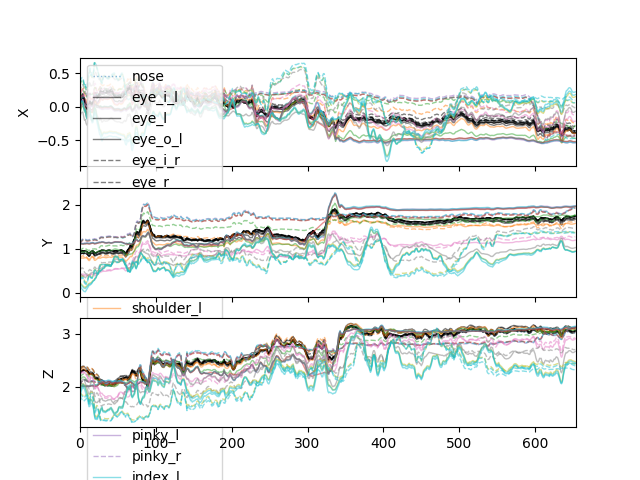

In [77]:

fig, axes = plt.subplots(3, 1, sharex=True)
coords = np.array([L_body_adjusted[i].coords3d for i in range(len(L_body_adjusted))])
for i in range(3):

    for kp in KEYPOINTS:
        c, ls = get_plot_style(kp)
        axes[i].plot(coords[:,get_kp_idx(kp),i], c=c, ls=ls, alpha=0.5, lw=1, label=kp)
    axes[i].set_ylabel(['X', 'Y', 'Z'][i])
    axes[i].set_xlim((0, videodata.total_frames))
# ax.plot(conf, alpha=0.5)
axes[0].legend()
plt.show()

# Matplotlib Animation

# Simple 3D plot

In [86]:
animation = '3d'

In [87]:
if animation == '3d':
    n_frames = videodata.total_frames
    # n_frames = 200
    fps = 30
    output_path = os.path.join(
        os.path.dirname(os.path.abspath('__file__')),
        os.pardir,
        os.pardir,
        'database',
        'animation_3d.mp4'
        )

In [88]:
if animation == '3d':
    """
    Fig and ax setup
    ax: 3d
    """
    # plt.ioff()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    def init_axes():
        """Initialize static axis properties."""
        xlim, ylim, zlim = ax_limits_mean
        views = [
            dict(elev=60, azim=164, roll=-104),
            dict(elev=0, azim=180, roll=-90),
            dict(elev=90, azim=-90, roll=0),
        ]
        ax.view_init(**views[0])
        ax.set_xlim3d(xlim)
        ax.set_ylim3d(ylim)
        ax.set_zlim3d(zlim)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_aspect('equal')
        
        # plane fit
        plane_coeffs = plane_fit(pts_wld)
        xx, yy = np.meshgrid(xyz_minmax[0], xyz_minmax[1])
        z = get_wall_z(xx, yy, *plane_coeffs)
        ax.plot_surface(xx, yy, z, alpha=0.1)

    init_axes()
    plt.tight_layout()

    """
    Animation Frame Update Function
    """

    def frame_update(frame_number):
        progress_bar.update(1)
        # Clear dynamic content from all axes
        ax.cla()

        body_adjusted = L_body_adjusted[frame_number]
        coords3d_contact = L_coords3d_contact[frame_number]
        pts_wld = L_pts_wld[frame_number]

        init_axes()  # Reset views and labels

        """
        Plots Update
        """
        # # plane fit
        # ax_limits, xyz_minmax = get_xyz_lims(pts_wld)
        # plane_coeffs = plane_fit(pts_wld)
        # xx, yy = np.meshgrid(xyz_minmax[0], xyz_minmax[1])
        # z = get_wall_z(xx, yy, *plane_coeffs)
        # ax.plot_surface(xx, yy, z, alpha=0.1)

        # body_adjusted.plot(ax, size_contact=30, size_com=10)
        for coords, col in zip(body_adjusted.edges3d.values(), body_adjusted.edges_col.values()):
            p0, p1 = coords
            xs, ys, zs = [p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]]
            ax.plot(xs, ys, zs, c=col)
        for point in body_adjusted.contact_points3d.dict_points.values():
            col = 'white'
            if point['state'] == 1:
                col = 'orange'
            x, y, z = point['coords']
            ax.scatter(x, y, z, marker='o', c=col, edgecolors='k', s=30)

        for key, val in body_adjusted.dict_com3d.items():
            x, y, z = val
            ax.scatter(x, y, z, marker='o', c='green', edgecolors='k', s=10)

        for pt in coords3d_contact:
            ax.scatter(*pt, marker='s', edgecolors='black', facecolors='none', s=100, linewidths=1)

        for coords in pts_wld:
            x, y, z = coords
            ax.scatter(x, y, z, c='black', s=3, alpha=0.2)


        ax.text2D(0.1, 0.95, f'Frame {frame_number} {frame_to_timestamp(frame_number, videodata.fps)}', transform=ax.transAxes,
                    fontsize=15, color='red', bbox=dict(facecolor='white', alpha=0.6))
        return []

    # Progressbar
    progress_bar = tqdm(total=n_frames)
    ani = FuncAnimation(fig, frame_update, frames=n_frames, blit=False, interval=1000/fps)
    ani.save(output_path, writer='ffmpeg', dpi=200)
    plt.close(fig)
    progress_bar.close()

655it [12:36,  1.16s/it]                         


# 2D (z-y, x-y, x-z) plot

In [83]:
animation = '2d'

In [84]:
if animation == '2d':
    n_frames = videodata.total_frames
    # n_frames = 200
    fps = 30
    output_path = os.path.join(
        os.path.dirname(os.path.abspath('__file__')),
        os.pardir,
        os.pardir,
        'database',
        'animation_2d.mp4'
        )

In [85]:
if animation == '2d':
    """
    Fig and ax setup
    ax1: z-y
    ax2: x-y
    ax3: along the wall?
    ax4: x-z
    """
    plt.ioff()
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)
    ax4 = fig.add_subplot(2, 2, 4, sharex=ax2)
    ax_all = [ax1, ax2, ax4]

    def init_axes():
        """Initialize static axis properties."""
        xlim, ylim, zlim = ax_limits_mean
        ax1.set_xlim(zlim)
        ax1.set_ylim(ylim)
        ax1.set_xlabel('Z')
        ax1.set_ylabel('Y')

        ax2.set_xlim(xlim)
        ax2.set_ylim(ylim)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')

        ax4.set_xlim(xlim)
        ax4.set_ylim(zlim)
        ax4.set_xlabel('X')
        ax4.set_ylabel('Z')

        for ax in (ax_all):
            ax.set_aspect('equal')
            ax.grid()


    init_axes()
    plt.tight_layout()

    """
    Animation Frame Update Function
    """

    def frame_update(frame_number):
        progress_bar.update(1)
        # Clear dynamic content from all axes
        for ax in ax_all:
            ax.cla()

        body_adjusted = L_body_adjusted[frame_number]
        pts_wld = L_pts_wld[frame_number]
        coords3d_contact = L_coords3d_contact[frame_number]

        init_axes()  # Reset views and labels

        """
        Plots Update
        """
        # plane fit
        ax_limits, xyz_minmax = get_xyz_lims(pts_wld)
        plane_coeffs = plane_fit(pts_wld)
        xx, yy = np.meshgrid(xyz_minmax[0], xyz_minmax[1])
        z = get_wall_z(xx, yy, *plane_coeffs)
        
        corners_zy = np.column_stack((z.flatten(), yy.flatten()))
        ax1.plot(*np.column_stack((corners_zy[3].flatten(), corners_zy[1].flatten())), c='black')

        corners_xy = np.column_stack((xx.flatten(), yy.flatten()))
        ax2.plot(*np.column_stack((corners_xy[0].flatten(), corners_xy[1].flatten())), c='black')
        ax2.plot(*np.column_stack((corners_xy[3].flatten(), corners_xy[1].flatten())), c='black')
        ax2.plot(*np.column_stack((corners_xy[0].flatten(), corners_xy[2].flatten())), c='black')
        ax2.plot(*np.column_stack((corners_xy[2].flatten(), corners_xy[3].flatten())), c='black')

        corners_xz = np.column_stack((xx.flatten(), z.flatten()))
        ax4.plot(*np.column_stack((corners_xz[0].flatten(), corners_xz[1].flatten())), c='black')
        ax4.plot(*np.column_stack((corners_xz[3].flatten(), corners_xz[1].flatten())), c='black')
        ax4.plot(*np.column_stack((corners_xz[0].flatten(), corners_xz[2].flatten())), c='black')
        ax4.plot(*np.column_stack((corners_xz[2].flatten(), corners_xz[3].flatten())), c='black')

        body_adjusted.plot(ax1, size_contact=20, size_com=10, dimensions='zy')
        body_adjusted.plot(ax2, size_contact=20, size_com=10, dimensions='xy')
        body_adjusted.plot(ax4, size_contact=20, size_com=10, dimensions='xz')

        for pt in coords3d_contact:
            ax1.scatter(pt[2], pt[1], marker='s', edgecolors='black', facecolors='none', s=100, linewidths=1)
            ax2.scatter(pt[0], pt[1], marker='s', edgecolors='black', facecolors='none', s=100, linewidths=1)
            ax4.scatter(pt[0], pt[2], marker='s', edgecolors='black', facecolors='none', s=100, linewidths=1)

        ax1.text(0.1, 0.95, f'Frame {frame_number} {frame_to_timestamp(frame_number, videodata.fps)}', transform=ax1.transAxes,
                    fontsize=15, color='red', bbox=dict(facecolor='white', alpha=0.6))
        return []

    # Progressbar
    progress_bar = tqdm(total=n_frames)
    ani = FuncAnimation(fig, frame_update, frames=n_frames, blit=False, interval=1000/fps)
    ani.save(output_path, writer='ffmpeg', dpi=200)
    plt.close(fig)
    progress_bar.close()

655it [03:40,  2.97it/s]                         


# Along the Wall

# Conf Level Plot

In [ ]:
if animation == 'conf':
    n_frames = videodata.total_frames
    # n_frames = 200
    fps = 30
    output_path = os.path.join(
        os.path.dirname(os.path.abspath('__file__')),
        os.pardir,
        os.pardir,
        'database',
        'animation_conf.mp4'
        )

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True)
coords = np.array([L_body_adjusted[i].coords3d for i in range(len(L_body_adjusted))])
for i in range(3):
    axes[i].set_ylabel(['X', 'Y', 'Z'][i])
    axes[i].set_xlim((0, videodata.total_frames))
    axes[i].plot(coords[:,:,i], alpha=0.5)
# ax.plot(conf, alpha=0.5)
plt.show()

In [ ]:
if animation == '2d':
    """
    Fig and ax setup
    ax1: z-y
    ax2: x-y
    ax3: x-z
    """
    plt.ioff()
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)
    ax3 = fig.add_subplot(2, 2, 4, sharex=ax2)
    ax_all = [ax1, ax2, ax3]

    def init_axes():
        """Initialize static axis properties."""
        xlim, ylim, zlim = ax_limits_mean
        ax1.set_xlim(zlim)
        ax1.set_ylim(ylim)
        ax1.set_xlabel('Z')
        ax1.set_ylabel('Y')

        ax2.set_xlim(xlim)
        ax2.set_ylim(ylim)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')

        ax3.set_xlim(xlim)
        ax3.set_ylim(zlim)
        ax3.set_xlabel('X')
        ax3.set_ylabel('Z')

        for ax in (ax_all):
            ax.set_aspect('equal')
            ax.grid()


    init_axes()
    plt.tight_layout()

    """
    Animation Frame Update Function
    """

    def frame_update(frame_number):
        progress_bar.update(1)
        # Clear dynamic content from all axes
        for ax in ax_all:
            ax.cla()

        body_adjusted = L_body_adjusted[frame_number]
        pts_wld = L_pts_wld[frame_number]

        ax_limits, xyz_minmax = get_xyz_lims(pts_wld)
        init_axes()  # Reset views and labels

        """
        Plots Update
        """
        # plane fit
        plane_coeffs = plane_fit(pts_wld)
        xx, yy = np.meshgrid(xyz_minmax[0], xyz_minmax[1])
        z = get_wall_z(xx, yy, *plane_coeffs)
        
        corners_zy = np.column_stack((z.flatten(), yy.flatten()))
        ax1.plot(*np.column_stack((corners_zy[3].flatten(), corners_zy[1].flatten())), c='black')

        corners_xy = np.column_stack((xx.flatten(), yy.flatten()))
        ax2.plot(*np.column_stack((corners_xy[0].flatten(), corners_xy[1].flatten())), c='black')
        ax2.plot(*np.column_stack((corners_xy[3].flatten(), corners_xy[1].flatten())), c='black')
        ax2.plot(*np.column_stack((corners_xy[0].flatten(), corners_xy[2].flatten())), c='black')
        ax2.plot(*np.column_stack((corners_xy[2].flatten(), corners_xy[3].flatten())), c='black')

        corners_xz = np.column_stack((xx.flatten(), z.flatten()))
        ax3.plot(*np.column_stack((corners_xz[0].flatten(), corners_xz[1].flatten())), c='black')
        ax3.plot(*np.column_stack((corners_xz[3].flatten(), corners_xz[1].flatten())), c='black')
        ax3.plot(*np.column_stack((corners_xz[0].flatten(), corners_xz[2].flatten())), c='black')
        ax3.plot(*np.column_stack((corners_xz[2].flatten(), corners_xz[3].flatten())), c='black')

        body_adjusted.plot(ax1, size_contact=20, size_com=10, dimensions='zy')
        body_adjusted.plot(ax2, size_contact=20, size_com=10, dimensions='xy')
        body_adjusted.plot(ax3, size_contact=20, size_com=10, dimensions='xz')

        ax1.text(0.1, 0.95, f'Frame {frame_number} {frame_to_timestamp(frame_number, videodata.fps)}', transform=ax1.transAxes,
                    fontsize=15, color='red', bbox=dict(facecolor='white', alpha=0.6))
        return []

    # Progressbar
    progress_bar = tqdm(total=n_frames)
    ani = FuncAnimation(fig, frame_update, frames=n_frames, blit=False, interval=1000/fps)
    ani.save(output_path, writer='ffmpeg', dpi=200)
    plt.close(fig)
    progress_bar.close()

# Combined

In [ ]:
if animation == '2d':
    """
    Fig and ax setup
    ax1: x-y
    ax2: y-z
    ax3: z-x
    ax4: x-y-z (3d)
    ax5: feature match
    ax5: video frame with annotation
    """
    plt.ioff()
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    ax3 = fig.add_subplot(2, 3, 3, projection='3d')
    ax4 = fig.add_subplot(2, 3, 4)
    ax5 = fig.add_subplot(2, 3, 5)
    ax6 = fig.add_subplot(2, 3, 6)
    ax3d = [ax1, ax2, ax3]
    ax2d = [ax4, ax5, ax6]

    def init_axes():
        """Initialize static axis properties."""
        views = [
            dict(elev=60, azim=164, roll=-104),
            dict(elev=0, azim=180, roll=-90),
            dict(elev=90, azim=-90, roll=0),
        ]
        for ax, view in zip(ax3d, views):
            ax.view_init(**view)
            ax.set_xlim3d(-1.5, 1.5)
            ax.set_ylim3d(0, 2.5)
            ax.set_zlim3d(0.2, 3.5)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_aspect('equal')
        for ax in ax2d:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')

        ax2.set_xticks([])
        ax2.set_xlabel('')
        ax3.set_zticks([])
        ax3.set_zlabel('')

    init_axes()
    plt.tight_layout()

    """
    Animation Frame Update Function
    """

    def frame_update(frame_number):
        progress_bar.update(1)
        # Clear dynamic content from all axes
        for ax in ax3d + ax2d:
            ax.cla()
        init_axes()  # Reset views and labels

        body_adjusted = L_body_adjusted[frame_number]
        coords3d_contact = L_coords3d_contact[frame_number]
        pts_wld = L_pts_wld[frame_number]
        img2 = L_img2[frame_number]
        img3 = L_img3[frame_number]
        pose2d_projection = L_pose2d_projection[frame_number]
        holds2d_projection = L_holds2d_projection[frame_number]

        """
        Plots Update
        """

        for ax in ax3d:
            # body_adjusted.plot(ax, size_contact=30, size_com=10)
            for coords, col in zip(body_adjusted.edges3d.values(), body_adjusted.edges_col.values()):
                p0, p1 = coords
                xs, ys, zs = [p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]]
                ax.plot(xs, ys, zs, c=col)
            for point in body_adjusted.contact_points3d.dict_points.values():
                col = 'white'
                if point['state'] == 1:
                    col = 'orange'
                x, y, z = point['coords']
                ax.scatter(x, y, z, marker='o', c=col, edgecolors='k', s=30)

            for key, val in body_adjusted.dict_com3d.items():
                x, y, z = val
                ax.scatter(x, y, z, marker='o', c='green', edgecolors='k', s=10)

            for pt in coords3d_contact:
                ax.scatter(*pt, marker='s', edgecolors='black', facecolors='none', s=100, linewidths=1)

            for coords in pts_wld:
                x, y, z = coords
                ax.scatter(x, y, z, c='black', s=3, alpha=0.5)

        for ax in ax2d:
            ax.set_xticks([])
            ax.set_yticks([])
        _img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        _img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
        ax5.imshow(_img3)
        ax6.imshow(_img2)
        for i in range(pose2d_projection.shape[0]):
            ax6.scatter(*pose2d_projection[i][0], s=5, c='red', alpha=0.9)

        for i in range(holds2d_projection.shape[0]):
            ax6.scatter(*holds2d_projection[i][0], c='white', s=2, alpha=0.9)

        ax1.text2D(0.1, 0.95, f'Frame {frame_number} {frame_to_timestamp(frame_number, videodata.fps)}', transform=ax1.transAxes,
                    fontsize=15, color='red', bbox=dict(facecolor='white', alpha=0.6))
        return []

    # Progressbar
    progress_bar = tqdm(total=n_frames)
    ani = FuncAnimation(fig, frame_update, frames=n_frames, blit=False, interval=1000/fps)
    ani.save(output_path, writer='ffmpeg', dpi=200)
    plt.close(fig)
    progress_bar.close()

In [ ]:
if animation == 'matplolib':
    # Progressbar
    progress_bar = tqdm(total=n_frames)
    ani = FuncAnimation(fig, frame_update, frames=n_frames, blit=False, interval=1000/fps)
    ani.save(output_path, writer='ffmpeg', dpi=200)
    plt.close(fig)
    progress_bar.close()